# Assignment 8: Times Series Analysis

In assignment 8 we perform time series analysis for milk production using the California dairy production data set to address the following questions:

1. Is the time series stationary?
2. Is there a significant seasonal component?
3. For the residual from the STL decomposition of the time series, what is the order of the ARMA(p,q) process that best fits?

We then forecast production for 12 months, reporting numeric values and plotting the confidence intervals. We try to answer:

1. Are the confidence intervals reasonably small compared to the forecast means?
2. How do the confidence intervals behave as time moves to the future?

### Preparation

Import required libraries:

In [9]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import statsmodels.graphics.tsaplots as splt
import statsmodels.tsa.arima_process as arima
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
import matplotlib.pyplot as plt

Define global options:

In [2]:
# Display plots inline
%matplotlib inline

# Display all outputs from cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Declare functions:

In [3]:
def plot_ts(ts, lab = ''):
    ts.plot()
    plt.title('Time series plot of ' + lab)
    plt.ylabel('Value')
    plt.xlabel('Date')

### Load the Data Set

We begin by loading the data set:

In [4]:
# Internet location of the data set
url = "https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/CADairyProduction.csv"

# Download the data into a dataframe object
dairy = pd.read_csv(url)

dairy

,Year,Month,Cotagecheese.Prod,Icecream.Prod,Milk.Prod,N.CA.Fat.Price,Month.Count,monthNumSqred,monthNumCubed
0,1995,Jan,4.370,51.595,2.112,0.9803,1,1,1
1,1995,Feb,3.695,56.086,1.932,0.8924,2,4,8
2,1995,Mar,4.538,68.453,2.162,0.8924,3,9,27
3,1995,Apr,4.280,65.722,2.130,0.8967,4,16,64
4,1995,May,4.470,73.730,2.227,0.8967,5,25,125
...,...,...,...,...,...,...,...,...,...
223,2013,Aug,2.169,78.382,3.400,1.6273,224,50176,11239424
224,2013,Sep,2.193,74.871,3.197,1.5519,225,50625,11390625
225,2013,Oct,2.284,70.011,3.338,1.5566,226,51076,11543176
226,2013,Nov,1.865,61.394,3.275,1.7537,227,51529,11697083


In this assignment we focus on milk production.

### Is Milk Production Stationary?

We now seek to answer the question as to whether milk production is stationary. First, we load the data into a series and plot:

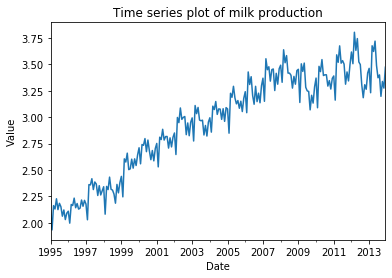

In [5]:
# Define date range for milk production
dates = pd.date_range(start='1-1995', end='1-2014', freq='M')

# Load data as a series
milk = pd.Series(dairy['Milk.Prod'].values, index=dates)

# Plot data
plot_ts(milk, 'milk production')

 Now we look for trends in the autocorrelation function (ACF) and partial autocorrelation function (PACF):

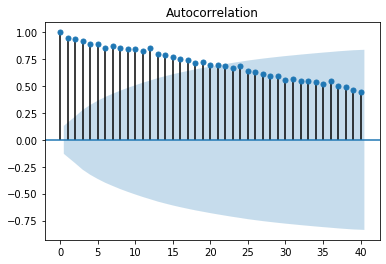

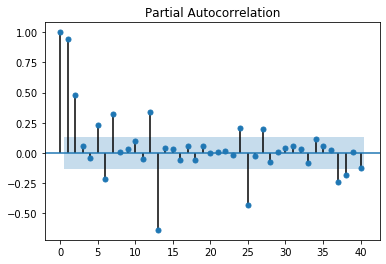

In [10]:
# Plot the ACF and PACF
_=splt.plot_acf(milk, lags = 40)
_=splt.plot_pacf(milk, lags = 40)

Note that the ACF decays steadily and the PACF exhibits significant values for several lags, showing that the trend creates a dependency from one value to the next. Hence, the time series for milk production is **not stationary**.

### Is Milk Production Seasonal?

We now determine if milk production has a seasonal component.

1. Is this time series stationary?
2. Is there a significant seasonal component?
3. Perform STL decomposition of the time series. Should this decomposition be performed with the
additive or multiplicative (log of values) model? Are the residuals stationary?
4. Use the auto_arima function from the pmdarima package to find a best model fit, excluding the last
12 months of observations from the training data, and setting d=1 and D=1 and limit p, q, P and Q to
3 with starting values of 1. Which model coefficients are statistically significant?
5. Then forecast the last 12 months and report both numeric values and plot the prediction vs. the
actual values. Would you say the predictions are close to the actual observations?
6. Are the residuals approximately Normally distributed?
7. What is the RMSE? Is this value small relative to the forecasted values?